In [1]:
import os
import string
import re

import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Generate graphs in SVG format
%config InlineBackend.figure_format = 'svg'

# get reproducible results
np.random.seed(1997)
tf.random.set_seed(1997)

In [2]:
df = pd.read_csv('data/presidential_speeches_cleaned.csv', encoding='utf-8', usecols=['Party', 'Transcript'])
df.sample(5)

,Party,Transcript
421,Democratic,My fellow Americans: Washington's Birthday is ...
373,Republican,Members of the American Bankers Association an...
648,Republican,"Officers, ladies and gentlemen of the National..."
256,Republican,To the Senate and House of Representatives: No...
615,Republican,"Mr. Chairman, delegates and alternates to this..."


In [3]:
df['Party'].value_counts()

Democratic    489
Republican    389
Name: Party, dtype: int64

In [4]:
X = df.drop('Party', axis=1)
y = df['Party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=97, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((702, 1), (176, 1), (702,), (176,))

In [5]:
OUTPUT_PATH = os.path.join(os.getcwd(), 'data/speeches_split')

for directory in (
        '', 
        'train', 
        'test', 
        'train/Republican', 
        'train/Democratic', 
        'test/Republican', 
        'test/Democratic'
    ):
    if not os.path.exists(os.path.join(OUTPUT_PATH, directory)):
        os.mkdir(os.path.join(OUTPUT_PATH, directory))

for i in range(len(X_train)):

    file_num = f'{i+1}'.zfill(4)
    label = y_train.iloc[i]

    with open(
        f'{OUTPUT_PATH}/train/{label}/{file_num}.txt',
        'w', encoding='utf-8'
    ) as f:
        f.write(X_train.iloc[i]['Transcript'])

In [6]:
for i in range(len(X_test)):

    file_num = f'{i+1}'.zfill(4)
    label = y_test.iloc[i]

    with open(
        f'{OUTPUT_PATH}/test/{label}/{file_num}.txt',
        'w', encoding='utf-8'
    ) as f:
        f.write(X_test.iloc[i]['Transcript'])

In [7]:
batch_size = 100

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{OUTPUT_PATH}/train',
    batch_size=batch_size,
    validation_split=0.1,
    labels='inferred',
    label_mode='binary',
    subset='training',
    seed=1997,
)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{OUTPUT_PATH}/train',
    batch_size=batch_size,
    validation_split=0.1,
    labels='inferred',
    label_mode='binary',
    subset='validation',
    seed=1997,
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    f'{OUTPUT_PATH}/test', batch_size=batch_size
)

print("\n")
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 702 files belonging to 2 classes.
Using 632 files for training.
Found 702 files belonging to 2 classes.
Using 70 files for validation.
Found 176 files belonging to 2 classes.


Number of batches in raw_train_ds: 7
Number of batches in raw_val_ds: 1
Number of batches in raw_test_ds: 2


In [8]:
from IPython.display import Markdown, display

# Examples
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(f"Example {i+1}:")
        print(text_batch.numpy()[i][:250])
        print('Republican' if label_batch.numpy()[i] == 1. else 'Democratic')
        display(Markdown('---'))

Example 1:
b"Good evening. I want to have a frank talk with you tonight about our most serious domestic problem. That problem is inflation. Inflation can threaten all the economic gains we've made, and it can stand in the way of what we want to achieve in the fut"
Democratic


---

Example 2:
b'IN APRIL 1928, as a result of discussions between our Secretary of State of the United States and the Minister of Foreign Affairs of France, the President directed Secretary Kellogg to propose to the nations of the world that they should enter into a'
Republican


---

Example 3:
b'I have just concluded a meeting with the leaders of the Congress. I reported to them on the serious situation in the Dominican Republic. I reported the decisions that this Government considers necessary in this situation in order to protect American '
Democratic


---

Example 4:
b'To the Senate and House of Representatives: The Constitution requires that the President \xe2\x80\x9cshall, from time to time, give to the Congress information of the state of the Union, and recommend to their consideration such measures as he shall judge nec'
Republican


---

Example 5:
b"Mr. Speaker, Mr. President, Members of the Congress, distinguished guests, and my fellow Americans: It's great to be home, and Nancy and I thank you for this wonderful homecoming. And before I go on, I want to say a personal thank you to Nancy. She w"
Republican


---

In [9]:
def clean(input_data):
    text = tf.strings.lower(input_data)
    return tf.strings.regex_replace(
        text, f'[{re.escape(string.punctuation)}]', ''
    )

# Constants for the model
max_features = 1000
embedding_dim = 128
sequence_length = 25

vect = keras.layers.TextVectorization(
    standardize=clean,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

text_ds = raw_train_ds.map(lambda x, y: x)
vect.adapt(text_ds)

In [10]:
# Vectorize the texts
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vect(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds   = raw_val_ds.map(vectorize_text)
test_ds  = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds   = val_ds.cache().prefetch(buffer_size=10)
test_ds  = test_ds.cache().prefetch(buffer_size=10)

## CNN

In [11]:
inputs = keras.Input(shape=(None,), dtype='int64')

x = keras.layers.Embedding(max_features, embedding_dim)(inputs)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Conv1D(128, 1, padding='same', activation='relu')(x)
x = keras.layers.Conv1D(128, 1, padding='same', activation='relu')(x)
x = keras.layers.GlobalMaxPooling1D()(x)

x = keras.layers.Dense(256, activation='relu', name='relu1')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu', name='relu2')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='softmax', name='softmax')(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(256, activation='softmax')(x)

output = keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Add early stopping to prevent overfitting, and the optimizer
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model = keras.Model(inputs, output)

# Compile the model with binary crossentropy loss and an adam optimizer
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         16512     
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         16512     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [12]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 7s 477ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 2/100
7/7 [==============================] - 0s 39ms/step - loss: 0.6933 - accuracy: 0.4415 - val_loss: 0.6932 - val_accuracy: 0.4571
Epoch 3/100
7/7 [==============================] - 0s 43ms/step - loss: 0.6932 - accuracy: 0.4415 - val_loss: 0.6932 - val_accuracy: 0.4571
Epoch 4/100
7/7 [==============================] - 0s 48ms/step - loss: 0.6932 - accuracy: 0.4415 - val_loss: 0.6931 - val_accuracy: 0.5429
Epoch 5/100
7/7 [==============================] - 0s 49ms/step - loss: 0.6931 - accuracy: 0.5585 - val_loss: 0.6931 - val_accuracy: 0.5429
Epoch 6/100
7/7 [==============================] - 0s 47ms/step - loss: 0.6931 - accuracy: 0.5585 - val_loss: 0.6931 - val_accuracy: 0.5429
Epoch 7/100
7/7 [==============================] - 0s 46ms/step - loss: 0.6930 - accuracy: 0.5585 - val_loss: 0.6930 - val_accuracy: 0.5429
Epoch 8/100
7/7 [==

In [13]:
model.evaluate(test_ds)

2/2 [==============================] - 2s 197ms/step - loss: 0.6893 - accuracy: 0.5568


[0.6893012523651123, 0.5568181872367859]

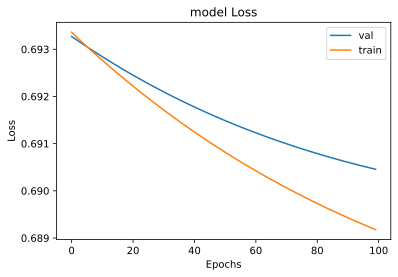

In [14]:
plt.plot(history.history['val_loss'], label='val')
plt.plot(history.history['loss'], label='train')
plt.title(f'{model.name} Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

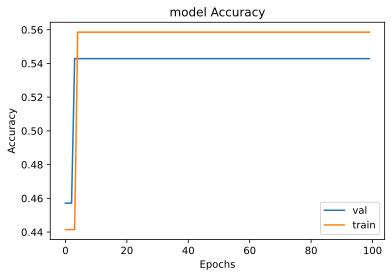

In [15]:
plt.plot(history.history['val_accuracy'], label='val')
plt.plot(history.history['accuracy'], label='train')
plt.title(f'{model.name} Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CNN (Sequential)

In [16]:
model2 = keras.models.Sequential()
# model2.add(keras.Input(shape=(None,), dtype='int64'))
model2.add(keras.layers.Input(shape=(None,)))

model2.add(keras.layers.Embedding(max_features, embedding_dim))
model2.add(keras.layers.Dropout(0.5))

model2.add(keras.layers.Conv1D(128, 1, padding='same', activation='relu'))
model2.add(keras.layers.Conv1D(128, 1, padding='same', activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())

model2.add(keras.layers.Dense(128, activation='relu', name='relu1'))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(256, activation='relu', name='relu2'))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(512, activation='softmax', name='softmax'))
model2.add(keras.layers.Dropout(0.5))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(256, activation='softmax'))

model2.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

# Add early stopping to prevent overfitting, and the optimizer
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.SGD(learning_rate=1e-4)

# Compile the model2 with binary crossentropy loss and an adam optimizer
model2.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         128000    
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         16512     
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         16512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 relu1 (Dense)               (None, 128)               16512     
                                                        

In [17]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 2s 98ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 2/100
7/7 [==============================] - 0s 40ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 3/100
7/7 [==============================] - 0s 45ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 4/100
7/7 [==============================] - 0s 47ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 5/100
7/7 [==============================] - 0s 48ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 6/100
7/7 [==============================] - 0s 47ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 7/100
7/7 [==============================] - 0s 48ms/step - loss: 0.6934 - accuracy: 0.4415 - val_loss: 0.6933 - val_accuracy: 0.4571
Epoch 8/100
7/7 [===

In [18]:
model2.evaluate(test_ds)

2/2 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.4432


[0.6931853890419006, 0.4431818127632141]

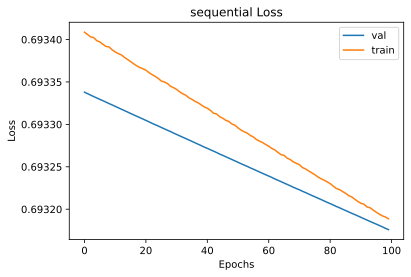

In [19]:
plt.plot(history2.history['val_loss'], label='val')
plt.plot(history2.history['loss'], label='train')
plt.title(f'{model2.name} Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

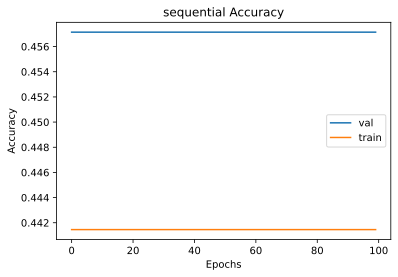

In [20]:
plt.plot(history2.history['val_accuracy'], label='val')
plt.plot(history2.history['accuracy'], label='train')
plt.title(f'{model2.name} Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Simple RNN

In [21]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Input(shape=(None,)))
model3.add(keras.layers.Embedding(max_features, embedding_dim))
model3.add(keras.layers.SimpleRNN(256, return_sequences=True))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(32, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

# Add early stopping to prevent overfitting, and the optimizer
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Compile model3
model3.compile(
    loss=keras.losses.MeanSquaredError(), 
    optimizer=optimizer, 
    metrics=['accuracy']
)
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         128000    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 256)         98560     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 234,817
Trainable params: 234,817
Non-trainable params: 0
________________________________________________

In [22]:
history3 = model3.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 3s 113ms/step - loss: 0.2848 - accuracy: 0.5079 - val_loss: 0.2482 - val_accuracy: 0.5429
Epoch 2/100
7/7 [==============================] - 0s 57ms/step - loss: 0.2500 - accuracy: 0.5585 - val_loss: 0.2482 - val_accuracy: 0.5429
Epoch 3/100
7/7 [==============================] - 0s 62ms/step - loss: 0.2531 - accuracy: 0.4984 - val_loss: 0.2544 - val_accuracy: 0.5429
Epoch 4/100
7/7 [==============================] - 1s 78ms/step - loss: 0.2500 - accuracy: 0.5585 - val_loss: 0.2482 - val_accuracy: 0.5429
Epoch 5/100
7/7 [==============================] - 0s 69ms/step - loss: 0.2482 - accuracy: 0.5585 - val_loss: 0.2493 - val_accuracy: 0.5429
Epoch 6/100
7/7 [==============================] - 0s 68ms/step - loss: 0.2489 - accuracy: 0.5585 - val_loss: 0.2485 - val_accuracy: 0.5429


In [23]:
model3.evaluate(test_ds)

2/2 [==============================] - 1s 22ms/step - loss: 0.2469 - accuracy: 0.5568


[0.24687662720680237, 0.5568181872367859]

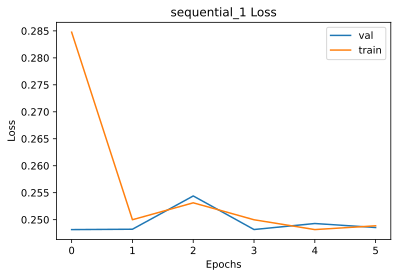

In [24]:
plt.plot(history3.history['val_loss'], label='val')
plt.plot(history3.history['loss'], label='train')
plt.title(f'{model3.name} Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

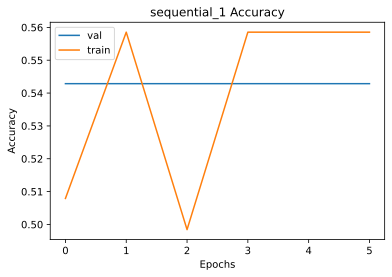

In [25]:
plt.plot(history3.history['val_accuracy'], label='val')
plt.plot(history3.history['accuracy'], label='train')
plt.title(f'{model3.name} Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## LSTM

In [44]:
model4 = keras.models.Sequential()
# model4.add(keras.layers.Input(shape=(None,)))
model4.add(keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length))
model4.add(keras.layers.LSTM(512, return_sequences=True))
model4.add(keras.layers.LSTM(256, return_sequences=True))
model4.add(keras.layers.Dense(1024, activation='relu'))
model4.add(keras.layers.Dropout(0.5))
model4.add(keras.layers.GlobalAveragePooling1D())
model4.add(keras.layers.Dense(1, activation='sigmoid', name='output'))

# Add early stopping to prevent overfitting, and the optimizer
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# Compile model4
model4.compile(
    loss=keras.losses.MeanSquaredError(), 
    optimizer=optimizer, 
    metrics=['accuracy']
)
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 128)           128000    
                                                                 
 lstm_8 (LSTM)               (None, 25, 512)           1312768   
                                                                 
 lstm_9 (LSTM)               (None, 25, 256)           787456    
                                                                 
 dense_4 (Dense)             (None, 25, 1024)          263168    
                                                                 
 dropout_4 (Dropout)         (None, 25, 1024)          0         
                                                                 
 global_average_pooling1d_4   (None, 1024)             0         
 (GlobalAveragePooling1D)                                        
                                                      

In [45]:
history4 = model4.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 22s 2s/step - loss: 0.2497 - accuracy: 0.5522 - val_loss: 0.2495 - val_accuracy: 0.5429
Epoch 2/100
7/7 [==============================] - 12s 2s/step - loss: 0.2487 - accuracy: 0.5585 - val_loss: 0.2490 - val_accuracy: 0.5429
Epoch 3/100
7/7 [==============================] - 13s 2s/step - loss: 0.2476 - accuracy: 0.5585 - val_loss: 0.2486 - val_accuracy: 0.5429
Epoch 4/100
7/7 [==============================] - 11s 2s/step - loss: 0.2462 - accuracy: 0.5585 - val_loss: 0.2486 - val_accuracy: 0.5429
Epoch 5/100
7/7 [==============================] - 10s 1s/step - loss: 0.2447 - accuracy: 0.5585 - val_loss: 0.2497 - val_accuracy: 0.5429
Epoch 6/100
7/7 [==============================] - 11s 2s/step - loss: 0.2435 - accuracy: 0.5585 - val_loss: 0.2503 - val_accuracy: 0.5429
Epoch 7/100
7/7 [==============================] - 9s 1s/step - loss: 0.2421 - accuracy: 0.5585 - val_loss: 0.2503 - val_accuracy: 0.5429
Epoch 8/100
7/7 [===========

In [46]:
model4.evaluate(test_ds)

2/2 [==============================] - 4s 395ms/step - loss: 0.2479 - accuracy: 0.5568


[0.24794340133666992, 0.5568181872367859]

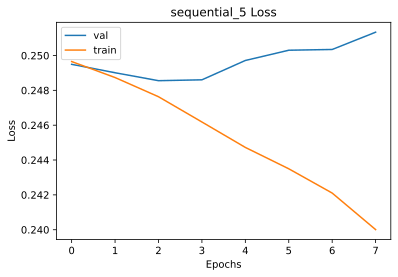

In [47]:
plt.plot(history4.history['val_loss'], label='val')
plt.plot(history4.history['loss'], label='train')
plt.title(f'{model4.name} Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

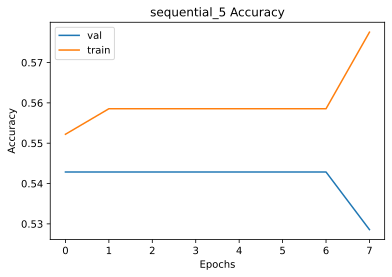

In [48]:
plt.plot(history4.history['val_accuracy'], label='val')
plt.plot(history4.history['accuracy'], label='train')
plt.title(f'{model4.name} Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
y_test.value_counts()

Democratic    98
Republican    78
Name: Party, dtype: int64

In [50]:
from sklearn.metrics import classification_report

predictions = [
    'Republican' if x > 0.5 else 'Democratic'
    for x in model4.predict(test_ds)
]

print(classification_report(predictions, y_test))

2/2 [==============================] - 2s 255ms/step
              precision    recall  f1-score   support

  Democratic       1.00      0.56      0.72       176
  Republican       0.00      0.00      0.00         0

    accuracy                           0.56       176
   macro avg       0.50      0.28      0.36       176
weighted avg       1.00      0.56      0.72       176



c:\github\predict-potus-affiliation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\github\predict-potus-affiliation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\github\predict-potus-affiliation\.venv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
false = 0
correct = 0

for x, y in zip(predictions, y_test):
    if x == y:
        correct += 1
    else:
        false += 1

print(f'Correct: {correct}')
print(f'False: {false}')
print(f'Percentage correct: {round(correct / (correct + false) * 100, 2)}')

Correct: 98
False: 78
Percentage correct: 55.68
